In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, sosfilt

In [2]:
# Define time
t_max = 400      # s
dt    = 0.00001  # s

t = np.arange(0, t_max, dt)
t

array([0.0000000e+00, 1.0000000e-05, 2.0000000e-05, ..., 3.9999997e+02,
       3.9999998e+02, 3.9999999e+02])

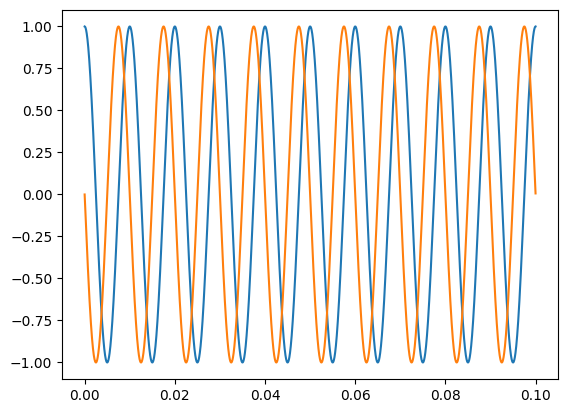

In [3]:
# Carrier wave
f_lo = 100 # hz
carrier_cos =  np.cos(2 * np.pi * f_lo * t)
carrier_sin = -np.sin(2 * np.pi * f_lo * t)

plt.plot(t[0:10000], carrier_cos[0:10000])
plt.plot(t[0:10000], carrier_sin[0:10000])
plt.show()

In [4]:
# Generate bitstream we want to send
bits_per_symbol = 8
bits_to_send = np.zeros(bits_per_symbol * 2**bits_per_symbol, dtype=int)
for i in range(2**bits_per_symbol):
    for j in range(bits_per_symbol):
        bits_to_send[i * bits_per_symbol + j] = (i & (1 << j)) >> j

bits_to_send

array([0, 0, 0, ..., 1, 1, 1])

In [5]:
# Turn bitstream into I and Q streams
def IQStreams(bitstream: np.array, bps: int) -> tuple:
    I, Q = [], []

    assert(bps % 2 == 0)
    assert(len(bits_to_send) % (bps // 2) == 0)
    for i in range(0, len(bitstream), bps):
        I_bits = 0
        for j in range(0, bps // 2):
            I_bits = I_bits | (bitstream[i + j] << j)

        Q_bits = 0
        for j in range(0, bps // 2):
            Q_bits= Q_bits| (bitstream[i + j + bps // 2] << j)

        I.append(I_bits)
        Q.append(Q_bits)
    
    return (np.array(I), np.array(Q))

I, Q = IQStreams(bits_to_send, bits_per_symbol)
I, Q

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,
         1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  1,
         2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  1,  2,
         3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  1,  2,  3,
         4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  1,  2,  3,  4,
         5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  1,  2,  3,  4,  5,
         6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  1,  2,  3,  4,  5,  6,
         7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  1,  2,  3,  4,  5,  6,  7,
         8,  9, 10, 11, 12, 13, 14, 15,  0,  1,  2,  3,  4,  5,  6,  7,  8,
         9, 10, 11, 12, 13, 14, 15,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
        10, 11, 12, 13, 14, 15,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        11, 12, 13, 14, 15,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
        12, 13, 14, 15,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        13, 

In [6]:
# Create I and Q signals
symbol_period = t_max / (len(bits_to_send) // bits_per_symbol)
print(symbol_period)

def IQStreamToSignal(I, Q, time, symbol_period):
    I_sig = np.zeros(len(time))
    Q_sig = np.zeros(len(time))

    samples_per_period = int(np.ceil(symbol_period / dt))
    print(samples_per_period)

    for i, s_i in enumerate(I):
        s_i_real = 2 * s_i / (bits_per_symbol // 2) - 1
        
        for j in range(i * samples_per_period, (i + 1) * samples_per_period):
            I_sig[j] = s_i_real

    for i, s_q in enumerate(Q):
        s_q_real = 2 * s_q / (bits_per_symbol // 2) - 1
        
        for j in range(i * samples_per_period, (i + 1) * samples_per_period):
            Q_sig[j] = s_q_real

    return (I_sig, Q_sig)

I_sig, Q_sig = IQStreamToSignal(I, Q, t, symbol_period)
I_sig, Q_sig

1.5625
156250


(array([-1. , -1. , -1. , ...,  6.5,  6.5,  6.5]),
 array([-1. , -1. , -1. , ...,  6.5,  6.5,  6.5]))

In [7]:
# Mix I,Q signals with carrier and sum
I_sig_if = I_sig * carrier_cos
Q_sig_if = Q_sig * carrier_sin

RF_sig = I_sig_if + Q_sig_if

# Plot them
# plt.figure(figsize=(15, 6))

# ax = plt.subplot(2, 2, 1)
# ax.plot(t, I_sig_if, label="I-Signal IF")
# ax.legend(loc='lower right')

# ax = plt.subplot(2, 2, 2)
# ax.plot(t, Q_sig_if, label="Q-Signal IF")
# ax.legend(loc='lower right')

# ax = plt.subplot(2, 2, 3)
# ax.plot(t, RF_sig, label="Final RF Signal")
# ax.legend(loc='lower right')

# plt.show()

In [8]:
# Demodulate signals
I_sig_demodulated = I_sig_if *  np.cos(2 * np.pi * f_lo * t)
Q_sig_demodulated = Q_sig_if * -np.sin(2 * np.pi * f_lo * t)

# plt.figure(figsize=(16, 2))

# ax = plt.subplot(1, 2, 1)
# ax.plot(t, I_sig_demodulated)

# ax = plt.subplot(1, 2, 2)
# ax.plot(t, Q_sig_demodulated)

# plt.show()

In [9]:
# Filter the I and Q signals
nyq = 0.5 * (1 / dt)
filter_cutoff = f_lo / 4 # dont know what would be good here
normalized_cutoff = filter_cutoff / nyq
filter = butter(5, normalized_cutoff, btype="low", output="sos")

I_filtered = sosfilt(filter, I_sig_demodulated)
Q_filtered = sosfilt(filter, Q_sig_demodulated)

# Plot
# plt.figure(figsize=(16, 2))

# ax = plt.subplot(1, 2, 1)
# ax.plot(t, I_filtered)

# ax = plt.subplot(1, 2, 2)
# ax.plot(t, Q_filtered)

# plt.show()

In [10]:
# Classify
I_class = []
Q_class = []

samples_per_symbol = int(np.ceil(symbol_period / dt))
num_symbols = int(np.ceil(len(I_filtered) / samples_per_symbol))
print(num_symbols)

for i in range(num_symbols):
    I_mean_val = np.mean(I_filtered[i * samples_per_symbol : (i+1) * samples_per_symbol])
    Q_mean_val = np.mean(Q_filtered[i * samples_per_symbol : (i+1) * samples_per_symbol])

    I_sym_class = int(np.round((I_mean_val + 0.5) * (bits_per_symbol // 2)))
    Q_sym_class = int(np.round((Q_mean_val + 0.5) * (bits_per_symbol // 2)))

    I_class.append(I_sym_class)
    Q_class.append(Q_sym_class)

I_class, Q_class

256


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10

In [11]:
# Turn I and Q back into bitstream
bitstream_decoded = []
for i in range(len(I_class)):
    for j in range(bits_per_symbol // 2):
        bitstream_decoded.append((I_class[i] & (1 << j)) >> j)

    for j in range(bits_per_symbol // 2):
        bitstream_decoded.append((Q_class[i] & (1 << j)) >> j)

print(bitstream_decoded)
for i in range(len(bitstream_decoded)):
    assert(bitstream_decoded[i] == bits_to_send[i])
print("Success! The two streams match :)")

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 